# Markov Chains & Markov Dynamics

Let's say an event can exist in two **states**, represented in a **State Vector** $S_t = \begin{bmatrix} s_{1,t} \\ s_{2,t} \end{bmatrix}$ (at time $t$), and there is a probability $p_{i,j}$ to transfer information from state $s_i$ to state $s_j$. All such probabilities can be accounted together in a **Transfer Matrix**, $P = \begin{bmatrix} p_{1,1} & p_{1,2} \\ p_{2,1} & p_{2,2} \end{bmatrix}$. Also given that these are probabilities, we have that $\sum_{j=1}^{n} p_{i,j} = 1$. We find:<br/>
&emsp;&emsp;&emsp;&emsp;$P_{2\times2} = \begin{bmatrix} 1-p_{1,2} & p_{1,2} \\ p_{2,1} & 1-p_{2,1} \end{bmatrix}$,<br/>
&emsp;&emsp;&emsp;&emsp;$P_{3\times3} = \begin{bmatrix}
    1-(p_{1,2}+p_{1,3}) & p_{1,2} & p_{1,3}\\
    p_{2,1} & 1-(p_{2,1}+p_{2,3}) & p_{2,3}\\
    p_{3,1} & 1-p_{3,2} & 1-(p_{3,1}+p_{3,2})
\end{bmatrix}$, and so on...


#### Markov Property:

1. Memory-lessness: the transfer matrix $P$ is not dependent on time or the value of information in the states prior to the present state.
2. Homogeneity: the function of information transfer will remain the same regardless of the information in the state. i.e. the probability of information transfer from State $s_i$ to $s_j$ will remain $p_{i,j}$ for all time $t$.

&emsp;&emsp;&emsp;&emsp;We can then write a function using these tranfer probabilities such that $s_{i,t+\Delta t} = \sum_{j=1}^{n} s_{j,t}\cdot p_{i,j}$, for all $i \in \{1,2,...,n\}$. Our new state vector $S$ at any given time $(t+\Delta t)$ can be written as:<br/>
&emsp;&emsp;&emsp;&emsp;$\begin{align}
S_{t+\Delta t} &= \begin{bmatrix}s_{i,t+\Delta t}\end{bmatrix}\\
&= \begin{bmatrix}\sum_{j=1}^{n} s_{j,t}\cdot p_{i,j}\end{bmatrix}\\
&= \begin{bmatrix}s_{i,t}\end{bmatrix}\cdot\begin{bmatrix}p_{i,j}\end{bmatrix}\\
\therefore S_{t+\Delta t} &= S_t\cdot P
\end{align}$

<br/>Simply put, a network of such events, connected by directed edges whose strength are the probabilities, is called a 'Markov Chain'.

<br/>

In [1]:
# Initialize Libraries
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
# Function calculates and collects all the states for the Markov Process
def solve_for_markov_process(init_state, transition_mat, iterate_len=0, convergence_rounding=5):
    init_state = np.asarray(init_state).ravel();
    transition_mat = np.asmatrix(transition_mat).T;
    sz = len(init_state);
    if len(init_state) != np.unique(transition_mat.shape): return [];
    
    # Iterate over the states if specific number of steps are provided...
    if iterate_len > 0:
        sn = np.zeros([iterate_len,sz]);
        sn[0,:] = init_state;
        for state in np.arange(1,iterate_len):
            sn[state,:] = np.asarray([
                np.dot(np.asarray(sn[state-1,:]).ravel(),np.asarray(el).ravel())
                for el in transition_mat
            ]);
        return sn;
    
    # Iterate over the states until convergence is reached...
    sn = [];
    sn.append(init_state);
    factval = np.math.factorial(sz);
    while True:
        if len(sn)>factval:
            idx = np.sort(len(sn) - np.arange(factval) - 1);
            idy = np.sort(len(sn) - np.arange(factval) - 2);
            if np.round(np.mean(
                np.asmatrix(sn[(len(sn)-factval):len(sn)]).ravel()
                - np.asmatrix(sn[(len(sn)-factval-1):(len(sn)-1)]).ravel(),
            axis=0), convergence_rounding).all() == 0:
                break;
        sn.append(np.asarray([
            np.dot(np.asarray(sn[-1]).ravel(),np.asarray(el).ravel())
            for el in transition_mat
        ]));
    return np.asarray(sn);

# Plots all Markov States based on the 'solve_for_markov_process()' function
def plot_markov_states(s0, p):
    sn = solve_for_markov_process(s0, p);
    plt.plot(sn, linewidth=2);
    plt.ylim([0,1]);
    plt.title(f'S_0 = {np.round(s0,3)}\nS_n = {np.round(np.asarray(sn)[-1,:],3)}');
    plt.grid();

# Draw/Plot the Markov Chain based on the Transfer Matrix (P)
def draw_markov_chain(p, layout_type=0, print_prob=True):
    fig = plt.figure(figsize=(10,7));
    ax = fig.add_subplot(111, aspect='equal');

    G = nx.DiGraph(p);
    if layout_type==1: pos = nx.planar_layout(G);
    elif layout_type==2: pos = nx.kamada_kawai_layout(G);
    else: pos = nx.circular_layout(G);
    if print_prob:
        [print(f'(S{edge[0]+1}, S{edge[1]+1}): {np.round(p[edge],4)}', end='\t\t') for edge in G.edges()];

    nx.draw(
        G, pos,
        edge_color='black', linewidths=1, width=np.asarray([G[i][j]['weight']*2.5 for i,j in G.edges()]),
        node_size=500, node_color='k', alpha=0.9, font_color='w',
        labels={node: f'S{node+1}' for node in G.nodes()},
        connectionstyle='arc3, rad=0.15'
    );
    plt.axis('off');

    fig.tight_layout(pad=3);
    plt.show();
    del fig, ax;

# Get Probabilities of State ending in an Absorbing State:
def get_p2as_prob(p):
    as_s = np.where(p==1)[0];               # Absorbing States (AS)
    if len(as_s)==0: return np.array([]);   # Check if P is Absorbing
    
    # Get the Non-Absorbing States (NAS)
    nas = np.setdiff1d(np.arange(p.shape[0]), as_s);
    reorder = np.append(np.asarray(as_s), nas);
    
    # Record the Sub-Matrices:
    I_m = np.eye(len(as_s));
    R = p[np.meshgrid(nas,as_s)].T;
    Q_n = p[np.meshgrid(nas,nas)].T;
    
    # Calculate the NAS to AS probabilities
    I_n = np.eye(len(nas));
    F = np.linalg.inv(I_n-Q_n);
    nas2as = F * R;
    
    # Return All-to-AS probabilities
    all2as = np.concatenate((I_m, nas2as), axis=0);
    return all2as[np.argsort(reorder),:];

<br/>

**Basic idea:**
<p>Let's assume that $t\rightarrow n$ and $\Delta t\rightarrow1$<br/>
    $S_{n+1} = S_n\cdot P$.&emsp;&emsp;&emsp;
    <br/>&emsp;&emsp;&emsp;where,$\ $$S_n$ := State Vector at instnace $n$.
    <br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$P$ := transition matrix of size $k\times k$.
</p>

$P$ maintains its transition values no matter what; i.e. it is temporally invariant.
<p style="margin-left:0.5in">
    i.e. if $S_0$ := initial state of a system;<br/>
    &emsp;&emsp;&emsp;$S_1 = S_0\cdot P$<br/>
    &emsp;&emsp;&emsp;$S_2 = S_1\cdot P = (S_0\cdot P)\cdot P = S_0\cdot P^2$<br/>
    &emsp;&emsp;&emsp;$S_3 = S_2\cdot P = (S_0\cdot P^2)\cdot P = S_0\cdot P^3$<br/>
    &emsp;&emsp;&emsp;$\vdots$<br/>
    &emsp;&emsp;&emsp;$S_n = S_0\cdot P^n$<br/>
</p><br/>

As an example, let $P = \begin{bmatrix}0.3 & 0.7\\1.0 & 0.0\end{bmatrix}$
and $\ S_0 = \begin{bmatrix}0.8 & 0.2\end{bmatrix}$;

We find:<br/>
$S_1 = \begin{bmatrix}0.44 & 0.56\end{bmatrix}$,<br/>
$S_2 = \begin{bmatrix}0.692 & 0.308\end{bmatrix}$,<br/>
$S_3 = \begin{bmatrix}0.516 & 0.484\end{bmatrix}$,<br/>
$\vdots$ <br/>
$S_S \approx \begin{bmatrix}0.588 & 0.412\end{bmatrix}$ at instance '$n_S$'.

Let's simulate this part...

P = [[0.3 0.7]
 [1.  0. ]]

(S1, S1): 0.3		(S1, S2): 0.7		(S2, S1): 1.0		

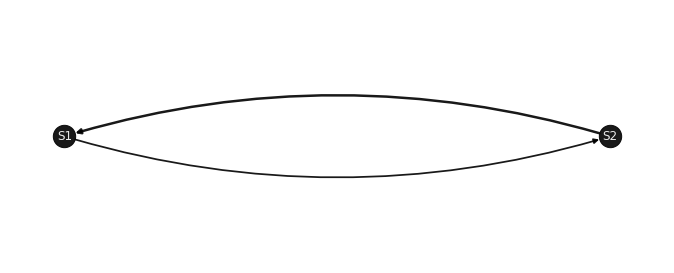

In [3]:
s0 = np.asarray([0.8, 0.2]);
p = np.asmatrix([[0.3,0.7],[1,0]]);

print(f'P = {np.round(p,4)}\n');
draw_markov_chain(p, layout_type=1);

All state transitions:

[[0.8        0.2       ]
 [0.44       0.56      ]
 [0.692      0.308     ]
 [0.5156     0.4844    ]
 [0.63908    0.36092   ]
 [0.552644   0.447356  ]
 [0.6131492  0.3868508 ]
 [0.57079556 0.42920444]
 [0.60044311 0.39955689]
 [0.57968982 0.42031018]
 [0.59421712 0.40578288]
 [0.58404801 0.41595199]
 [0.59116639 0.40883361]
 [0.58618353 0.41381647]
 [0.58967153 0.41032847]
 [0.58722993 0.41277007]
 [0.58893905 0.41106095]
 [0.58774266 0.41225734]
 [0.58858013 0.41141987]
 [0.58799391 0.41200609]
 [0.58840427 0.41159573]
 [0.58811701 0.41188299]
 [0.58831809 0.41168191]
 [0.58817734 0.41182266]
 [0.58827586 0.41172414]
 [0.5882069  0.4117931 ]
 [0.58825517 0.41174483]
 [0.58822138 0.41177862]
 [0.58824504 0.41175496]
 [0.58822848 0.41177152]
 [0.58824007 0.41175993]
 [0.58823195 0.41176805]
 [0.58823763 0.41176237]
 [0.58823366 0.41176634]]


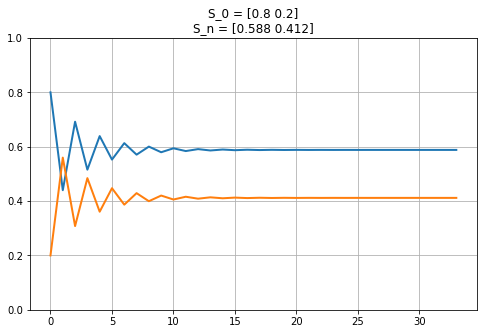

In [4]:
# The function 'solve_for_markov_process' calculates all transitions
print('All state transitions:\n');
print(solve_for_markov_process(s0, p));

# The function 'plot_markov_states' plots all 'solve_for_markov_process' outputs
fig = plt.figure(figsize=(8,5));
ax = fig.add_subplot(111);
plot_markov_states(s0, p);
plt.show();
del fig, ax;

In fact, we find that if $S_n = S_S$, then $S_{n+1} = S_S$.

Such states, $S_S$, are called **Steady States**. All transfer matrices ($P$) which end in such states are called **Regular Markov chains**. These markov chains have a property where the chain will converge at the Steady State no matter what the initial state ($S_0$) is.

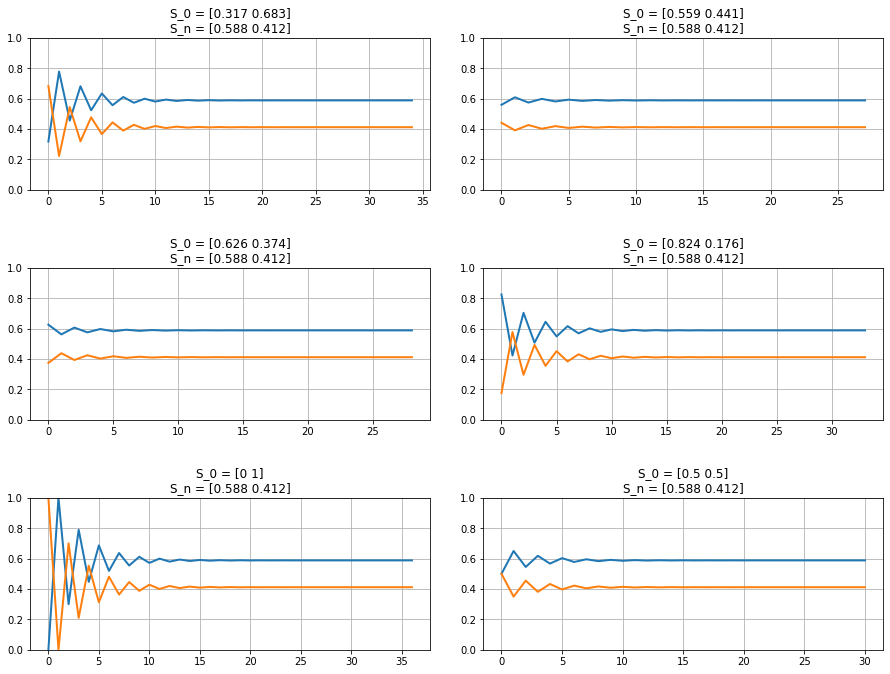

In [5]:
fig = plt.figure(figsize=(13,10));
for el in np.arange(4)+1:
    s0 = np.absolute(np.random.random(p.shape[0]));
    s0 /= np.sum(s0);
    ax = fig.add_subplot(3,2,el);
    plot_markov_states(s0, p);
del el;

ax = fig.add_subplot(3,2,5); plot_markov_states(np.array([0,1]), p);
ax = fig.add_subplot(3,2,6); plot_markov_states(np.array([1,1])/p.shape[0], p);

fig.tight_layout(pad=3);
plt.show();
del fig, ax, s0;

<br/><big>This holds true for most real-life markovv chain models, no matter the size of the model. For example:</big>

P = [[0.4861 0.2986 0.2153]
 [0.435  0.3236 0.2413]
 [0.5018 0.0763 0.4219]]

(S1, S1): 0.4861		(S1, S2): 0.2986		(S1, S3): 0.2153		(S2, S1): 0.435		(S2, S2): 0.3236		(S2, S3): 0.2413		(S3, S1): 0.5018		(S3, S2): 0.0763		(S3, S3): 0.4219		

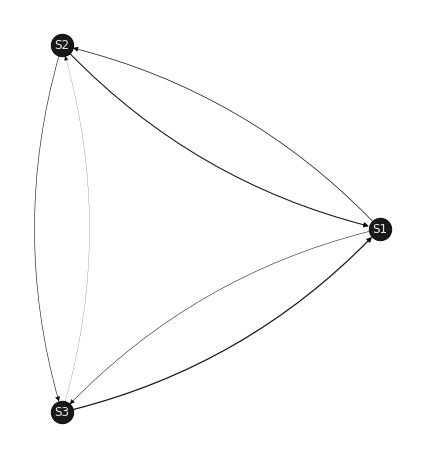

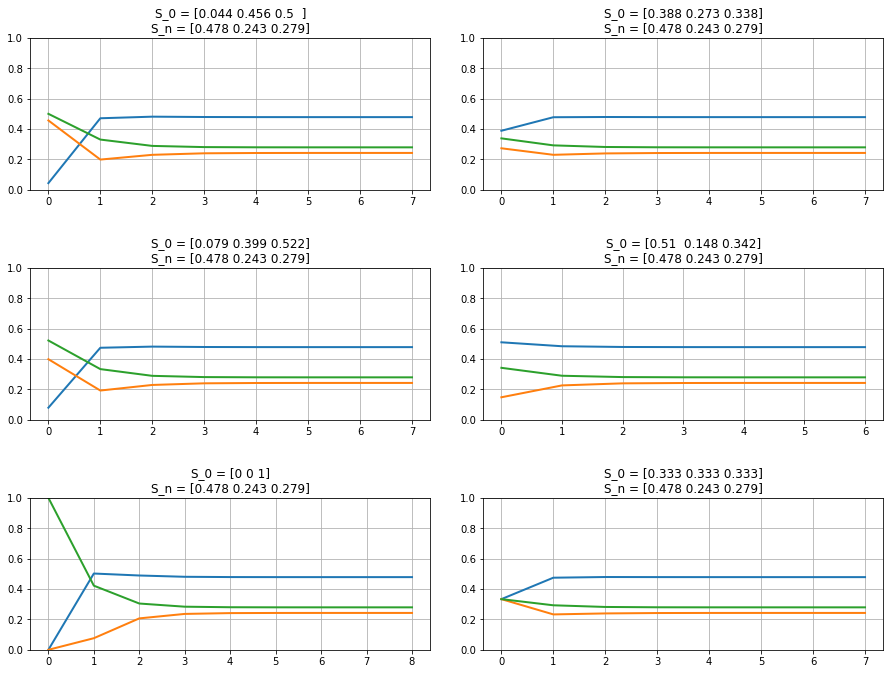

In [6]:
# Size-3 Markov Chains:
sz = 3;

p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
print(f'P = {np.round(p,4)}\n');
draw_markov_chain(p);

fig = plt.figure(figsize=(13,10));
for el in np.arange(4)+1:
    s0 = np.absolute(np.random.random(p.shape[0]));
    s0 /= np.sum(s0);
    ax = fig.add_subplot(3,2,el);
    plot_markov_states(s0, p);
del el;

ax7 = fig.add_subplot(3,2,5); plot_markov_states(np.array([0,0,1]), p);
ax8 = fig.add_subplot(3,2,6); plot_markov_states(np.array([1,1,1])/3, p);

fig.tight_layout(pad=3);
plt.show();
del fig, ax, s0, sz;

P = [[0.24   0.2761 0.0578 0.209  0.2171]
 [0.338  0.2698 0.1282 0.1428 0.1212]
 [0.179  0.2424 0.0708 0.2882 0.2196]
 [0.134  0.2615 0.2093 0.0534 0.3417]
 [0.1129 0.4417 0.0193 0.0781 0.3479]]

(S1, S1): 0.24		(S1, S2): 0.2761		(S1, S3): 0.0578		(S1, S4): 0.209		(S1, S5): 0.2171		(S2, S1): 0.338		(S2, S2): 0.2698		(S2, S3): 0.1282		(S2, S4): 0.1428		(S2, S5): 0.1212		(S3, S1): 0.179		(S3, S2): 0.2424		(S3, S3): 0.0708		(S3, S4): 0.2882		(S3, S5): 0.2196		(S4, S1): 0.134		(S4, S2): 0.2615		(S4, S3): 0.2093		(S4, S4): 0.0534		(S4, S5): 0.3417		(S5, S1): 0.1129		(S5, S2): 0.4417		(S5, S3): 0.0193		(S5, S4): 0.0781		(S5, S5): 0.3479		

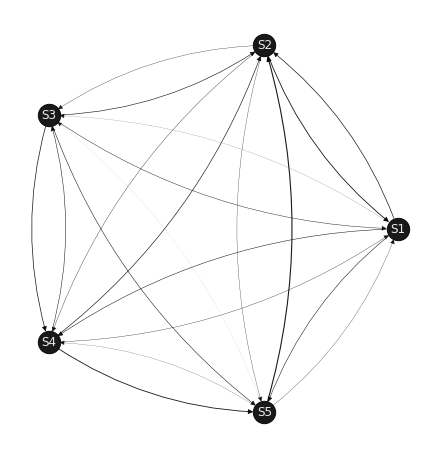

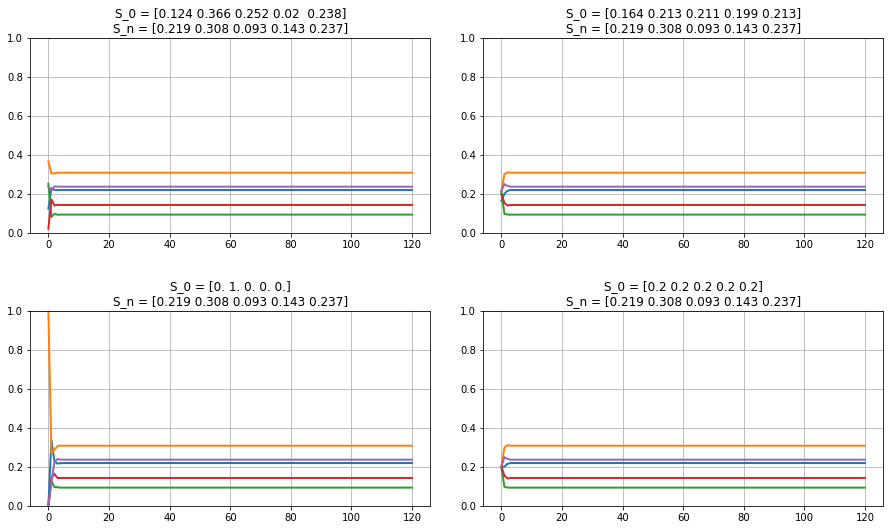

In [7]:
# Size-5 Markov Chains:
sz = 5;

p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
print(f'P = {np.round(p,4)}\n');
draw_markov_chain(p);

fig = plt.figure(figsize=(13,8));
for el in np.arange(2)+1:
    s0 = np.absolute(np.random.random(sz));
    s0 /= np.sum(s0);
    ax = fig.add_subplot(2,2,el);
    plot_markov_states(s0, p);
del el;

s0 = np.zeros(sz); s0[np.random.choice(np.arange(sz))] = 1;
ax = fig.add_subplot(2,2,3); plot_markov_states(s0, p);
ax = fig.add_subplot(2,2,4); plot_markov_states(np.ones(sz)/sz, p);

fig.tight_layout(pad=3);
plt.show();
del fig, ax, s0, sz;

<br/>... even size-105 markov chains, but that will require a lot of computational power. So, let's jump to a different type of markov chains/states...

##### Absorbing Markov Chains and Absorbing States:

Absorbing Markov Chains are such that there exists at least one such node/state that only has connections coming inwards and that all nodes/states can be linked to it. That is, if the transfer matrix, $P = P_A$, has one or more elements which is of the type $[0,0,...0,1,0,...,0]$, then all transitions to the state are possible, but a transition out of this state is not possible. In this case, the transfer matrix ends in an Absorbing State ($S_A$), such that all the values of vector $S$ are zero except $S[k] = 1$.

Let's take the example of Size-3 Markov chain from earlier, and make one state absorbing...

P = [[0.5307 0.1725 0.2968]
 [0.     1.     0.    ]
 [0.1436 0.3998 0.4566]]

(S1, S1): 0.5307		(S1, S2): 0.1725		(S1, S3): 0.2968		(S2, S2): 1.0		(S3, S1): 0.1436		(S3, S2): 0.3998		(S3, S3): 0.4566		

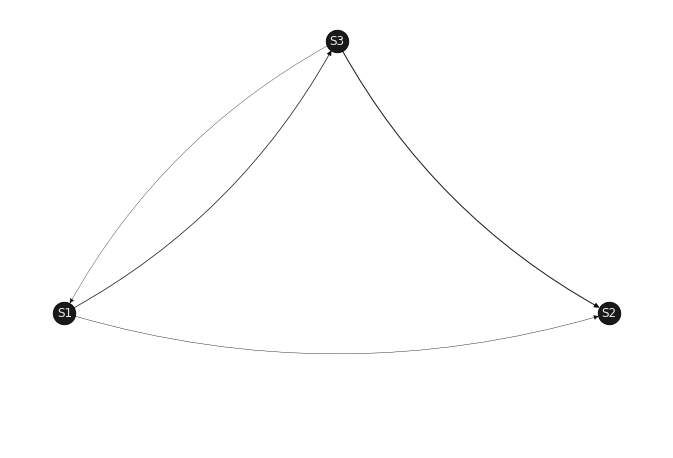

That is, S2 is the Absorbing State.



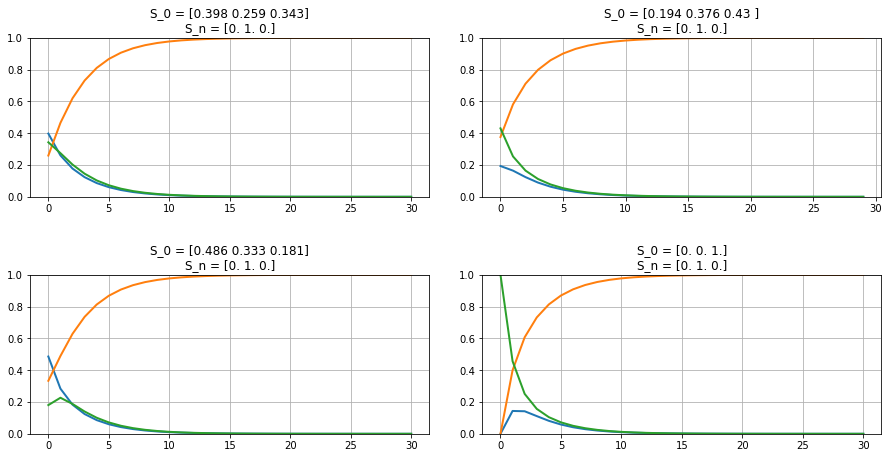

In [8]:
sz = 3; abs_state = np.random.choice(sz);

p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
p[abs_state,:] = 0; p[abs_state,abs_state] = 1;
print(f'P = {np.round(p,4)}\n');
draw_markov_chain(p, layout_type=1);
print(f'That is, S{abs_state+1} is the Absorbing State.\n');

fig = plt.figure(figsize=(13,7));
for el in np.arange(3)+1:
    s0 = np.absolute(np.random.random(p.shape[0]));
    s0 /= np.sum(s0);
    ax = fig.add_subplot(2,2,el);
    plot_markov_states(s0, p);
del el;

s0 = np.zeros(p.shape[0]);
s0[np.random.choice(np.setdiff1d(np.arange(p.shape[0]),abs_state))]=1;
ax = fig.add_subplot(2,2,4); plot_markov_states(s0, p);

fig.tight_layout(pad=3);
plt.show();
del fig, ax, s0, sz, abs_state;

<br/>Such tranfer matrices have the form of: $P_{A\ ((m+n)\times(m+n))} = \begin{bmatrix}I_m&O\\R&Q_n\end{bmatrix}$.

One can then define the _Fundamental Matrix_ as: $F_n = (I_n - Q_n)^{-1}$;

And then find the matrix of probabilities of starting in Non-Absorbing State and ending in an Absorbing State as $F\cdot R$.

<br/><hr/><br/>

Let's try this out for the problem above. We already know what the Markov Chain looks like...

In [9]:
# Absorbing States (AS)
as_s = np.where(p==1)[0];

# Get the Non-Absorbing States (NAS)
nas = np.setdiff1d(np.arange(p.shape[0]), as_s);

# Reorder the matrix to get the form for Absorbing Transfer Matrix:
reorder = np.append(np.asarray(as_s), nas);
p_absorbing = p[np.meshgrid(reorder,reorder)].T;

print(f'\nP-Absorbing (re-ordered P):\n{p_absorbing}');

# Storing the Sub-Matrices:
I_m = np.eye(len(as_s));
R = p[np.meshgrid(nas,as_s)].T;
Q_n = p[np.meshgrid(nas,nas)].T;

# Calculate the NAS to AS probabilities
I_n = np.eye(len(nas));
F = np.linalg.inv(I_n-Q_n);
nas2as = F * R;

print(f'\nProbabilities that NAS will end up in AS: (re-ordered list)\n{nas2as}');

# Add AS-to-AS with NAS-to-AS probabilities
all2as = np.concatenate((I_m, nas2as), axis=0);

# Re-arrange all the values according to the list of the States:
print(f'\nAll arranged probabilities:\n{all2as[np.argsort(reorder),:]}');


P-Absorbing (re-ordered P):
[[1.         0.         0.        ]
 [0.17245987 0.53070445 0.29683568]
 [0.39980496 0.14364356 0.45655148]]

Probabilities that NAS will end up in AS: (re-ordered list)
[[1.]
 [1.]]

All arranged probabilities:
[[1.]
 [1.]
 [1.]]


/Users/f004p57/miniforge3/envs/py38/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:193: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = N.ndarray.__getitem__(self, index)


<br/>
<big>
    The calculations reflect those from the function <i>get_p2as_prob( )</i><br/>
</big>

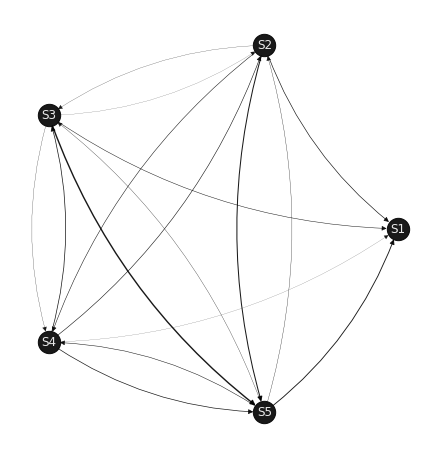

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [10]:
sz = 5; abs_state = np.random.choice(sz);
p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
p[abs_state,:] = 0; p[abs_state,abs_state] = 1;

draw_markov_chain(p, print_prob=False);
p2as = get_p2as_prob(p);
print(p2as);

<br/>
<big>
    &emsp;&emsp;&emsp;Note that the list is all 1's because only 1 Absorbing State (AS) exists in this case. What if more were added? Given below, are examples with 2 and 3 absorbing states. Notice that the probabilities of escaping these states is 0, i.e. if one begins from an AS, they cannot transition out of the state...
</big>

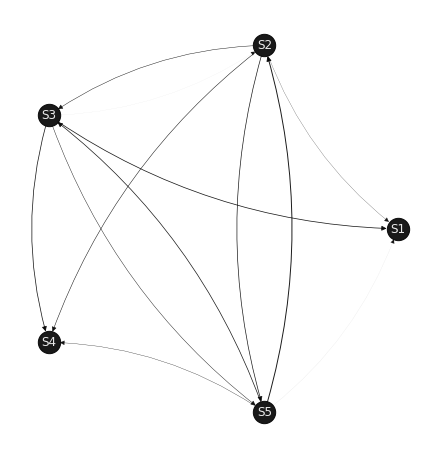

[[1.         0.        ]
 [0.35361463 0.64638537]
 [0.46319507 0.53680493]
 [0.         1.        ]
 [0.34564606 0.65435394]]


In [11]:
sz = 5; abs_state = np.random.choice(sz, 2, replace=False);
p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
p[abs_state,:] = 0; p[abs_state,abs_state] = 1;

draw_markov_chain(p, print_prob=False);
p2as = get_p2as_prob(p);
print(p2as);

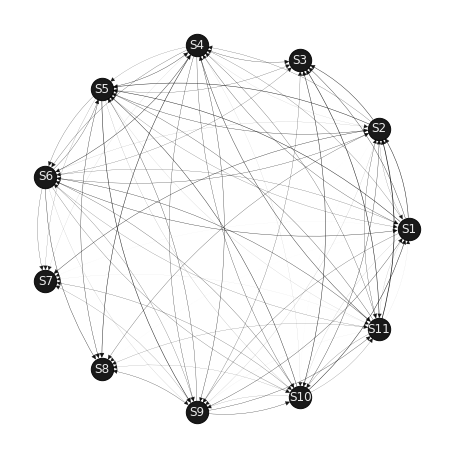

[[0.51752827 0.18403087 0.29844086]
 [0.43057066 0.26129768 0.30813166]
 [1.         0.         0.        ]
 [0.4247497  0.15860216 0.41664814]
 [0.40347214 0.20166047 0.39486738]
 [0.39216206 0.2268649  0.38097304]
 [0.         1.         0.        ]
 [0.         0.         1.        ]
 [0.42881406 0.20504263 0.36614332]
 [0.49104338 0.22680346 0.28215315]
 [0.51578682 0.17378855 0.31042462]]


In [12]:
sz = 11; abs_state = np.random.choice(sz, 3, replace=False);
p = np.absolute(np.random.random([sz,sz]));
p = np.asmatrix([el/np.sum(el) for el in p]);
p[abs_state,:] = 0; p[abs_state,abs_state] = 1;

draw_markov_chain(p, print_prob=False);
p2as = get_p2as_prob(p);
print(p2as);